## We select from the dataset only the position on each 10th timestep
## We choose a window of 18 time steps
## We want to learn 17 steps and predict 1 steps.
## Each step = 10 seconds

In [47]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [48]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [49]:
# show head
print(data.shape)
data.head()

(4597200, 6)


pos.x     pos.y     pos.z   heading  velocity  weather
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2

In [50]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [51]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [52]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [54]:
data.head()

pos.x     pos.y     pos.z   heading  velocity  weather    Minute sin  \
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2 -1.792514e-08   
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2  1.045284e-01   
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2  2.079117e-01   
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2  3.090170e-01   
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2  4.067366e-01   

   Minute cos  
0    1.000000  
1    0.994522  
2    0.978148  
3    0.951057  
4    0.913545

In [55]:
temp = data

### Sub-sampling the data

We start by sub-sampling the data from 1 second intervals to 10 seconds intervals

In [56]:
# Starting from index 10 take every 10th record.
data = data[10::10]

In [57]:
# show head
print(data.shape)
data.head()

(459719, 8)


pos.x     pos.y     pos.z   heading   velocity  weather    Minute sin  \
10 -76.220856 -1.436090  0.042877 -1.651711   8.587500        2  8.660254e-01   
20 -71.958855 -1.998021  0.042595 -1.702724  20.223438        2  8.660254e-01   
30 -66.829414 -2.400275  0.042382 -1.634385  16.974742        2  5.008168e-09   
40 -62.348705 -2.540402  0.042411 -1.598702  15.414865        2 -8.660254e-01   
50 -57.766743 -2.609079  0.060535 -1.583040  19.992627        2 -8.660254e-01   

    Minute cos  
10         0.5  
20        -0.5  
30        -1.0  
40        -0.5  
50         0.5

In [58]:
data = data.head(459702)

### Windowing
We choose a window of 18 time steps
We want to learn 17 steps and predict 1 steps.

In [59]:
window_size = 6
grouped_data = windowing_array(data, window_size)

In [60]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76617
6
8


### Slice and Split sequence 

In [61]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [62]:
x_train_init.shape, x_test_init.shape

((61293, 6, 8), (15324, 6, 8))

In [63]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence(x_train_init)

In [64]:
x_train.shape, y_train.shape

((61293, 5, 8), (61293, 1, 8))

In [65]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [66]:
y_train.shape

(61293, 1, 2)

In [67]:
y_train = y_train.reshape((-1, y_train.shape[-1]))

In [68]:
y_train.shape

(61293, 2)

In [74]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence(x_test_init)

In [75]:
x_test.shape, y_test.shape

((15324, 5, 8), (15324, 1, 8))

In [77]:
x_test[0].shape

(5, 8)

In [78]:
x_test[0]

array([[ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.09866959e-06,  2.00000000e+00,
         8.66025401e-01,  5.00000005e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.51230820e-06,  2.00000000e+00,
         8.66025407e-01, -4.99999995e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  3.43333659e-07,  2.00000000e+00,
         6.92111817e-09, -1.00000000e+00],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.51069378e-06,  2.00000000e+00,
        -8.66025400e-01, -5.00000007e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  3.50273606e-06,  2.00000000e+00,
        -8.66025408e-01,  4.99999993e-01]])

In [25]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [26]:
y_test.shape

(15324, 1, 2)

In [27]:
y_test = y_test.reshape((-1, y_test.shape[-1]))

In [28]:
y_test.shape

(15324, 2)

### Model Configuration

In [29]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(5, 8)

In [30]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2,)

In [31]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 1 # size of the prediction
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

2

### Train and evaluate

In [32]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [33]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [34]:
epochs = 5
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_dest.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
1533/1533 [==============================] - 21s 12ms/step - loss: 668.7636 - mae: 17.0162 - val_loss: 126.2524 - val_mae: 6.9761 - lr: 0.0010
Epoch 2/5
1533/1533 [==============================] - 19s 12ms/step - loss: 354.9008 - mae: 13.5184 - val_loss: 124.5128 - val_mae: 6.7258 - lr: 0.0010
Epoch 3/5
1533/1533 [==============================] - 19s 12ms/step - loss: 347.2416 - mae: 13.3594 - val_loss: 118.2693 - val_mae: 6.2287 - lr: 0.0010
Epoch 4/5
1533/1533 [==============================] - 19s 12ms/step - loss: 341.7344 - mae: 13.1962 - val_loss: 117.2483 - val_mae: 6.4871 - lr: 0.0010
Epoch 5/5
1533/1533 [==============================] - 19s 12ms/step - loss: 338.6359 - mae: 13.1509 - val_loss: 126.7097 - val_mae: 6.8949 - lr: 0.0010


In [37]:
#model.summary()

In [35]:
model = keras.models.load_model("best_model_dest.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

479/479 [==============================] - 2s 4ms/step - loss: 103.8209 - mae: 6.2035
Test accuracy 6.2035040855407715
Test loss 103.82085418701172


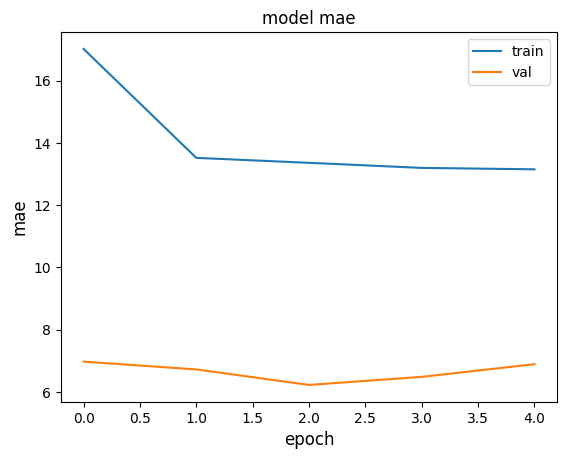

In [36]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [37]:
predictions = model.predict(x_test)

479/479 [==============================] - 2s 4ms/step


In [38]:
predictions.shape

(15324, 2)

Visualize some few predictions


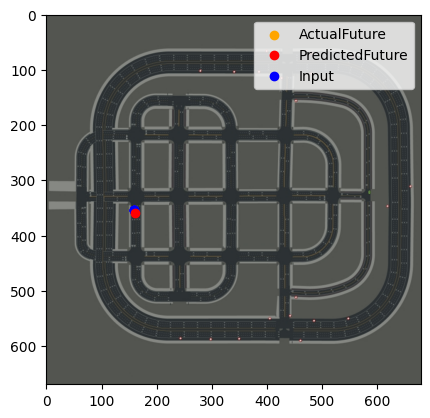

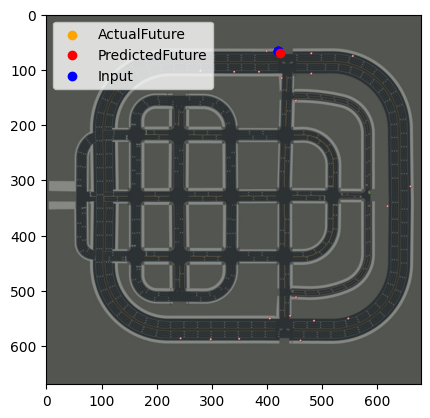

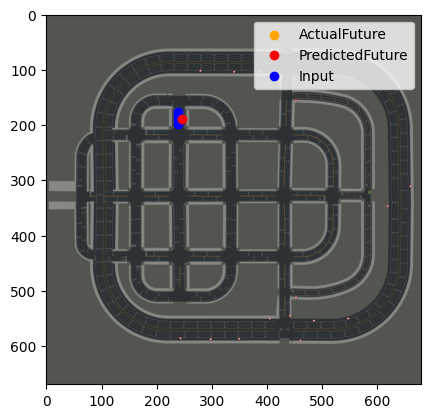

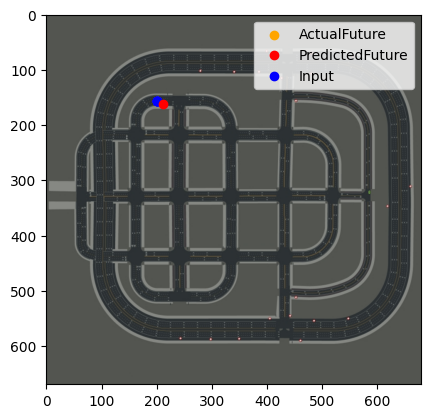

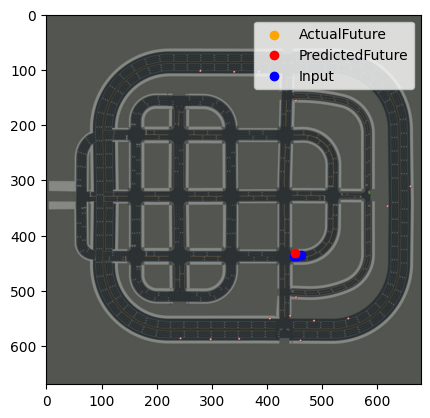

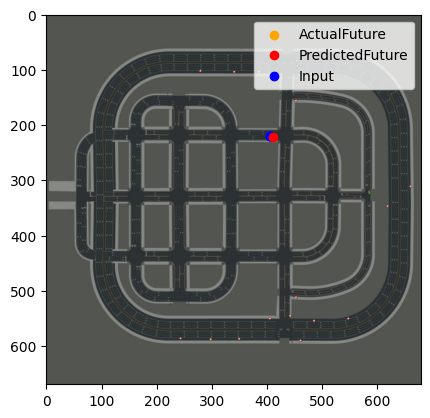

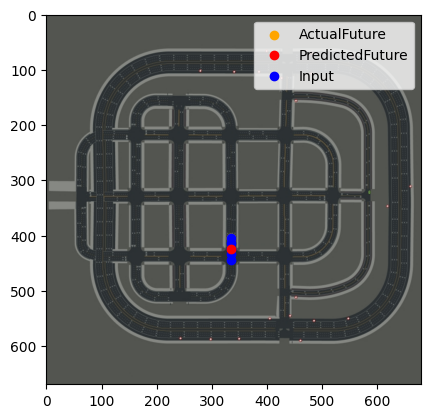

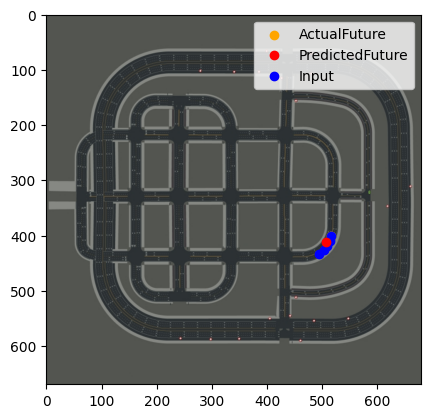

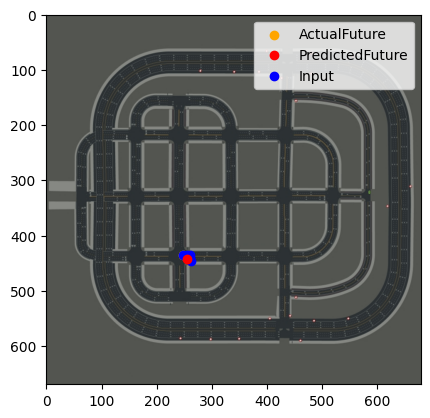

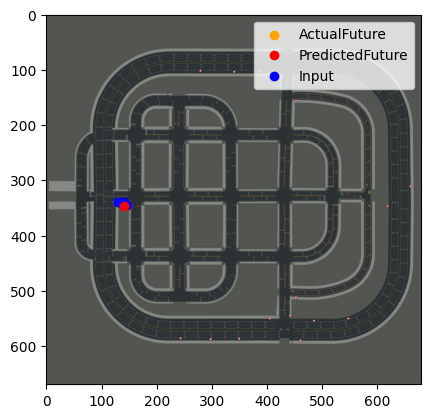

In [39]:
import random
from configs.utils_2 import plot_pred


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

### LIME

In [40]:
from lime import lime_tabular

In [42]:
explainer = lime_tabular.RecurrentTabularExplainer(
    x_train, 
    training_labels=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    discretize_continuous=True,
    class_names=['pos.x', 'pos.y'],
    discretizer='decile')

In [43]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(0,))
exp.show_in_notebook()

157/157 [==============================] - 1s 3ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [44]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

157/157 [==============================] - 1s 3ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


### Shape

In [45]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [46]:
x_test_0 = x_test[0]
x_train_0 = x_train[0]

In [47]:
x_test.shape

(15324, 5, 8)

In [48]:
x_test_0.shape, x_train_0.shape

((5, 8), (5, 8))

In [53]:
from explainers.explainer import BlackBoxWrapper


myBlackbox = BlackBoxWrapper(model)

In [54]:
explainer = shap.KernelExplainer(model=myBlackbox.predict, data=x_train_0, feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

1/1 [==============================] - 0s 208ms/step


In [55]:
shap_values = explainer.shap_values(x_test_0)

  0%|          | 0/5 [00:00<?, ?it/s]

20/20 [==============================] - 0s 4ms/step


In [56]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_0)

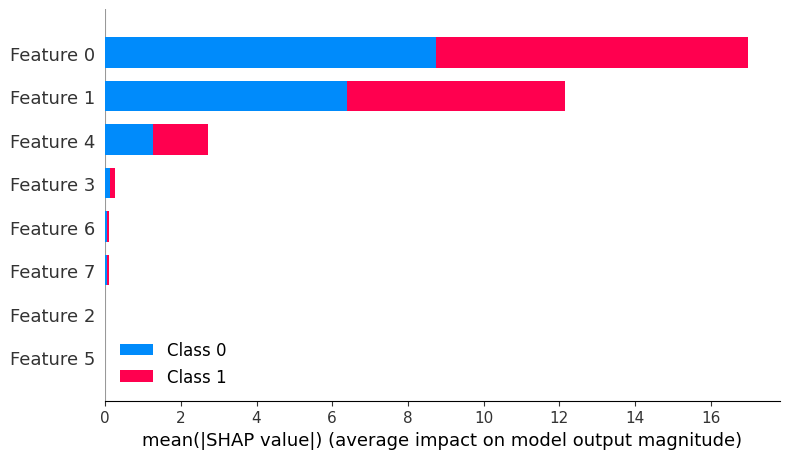

In [57]:
shap.summary_plot(shap_values, x_test_0)

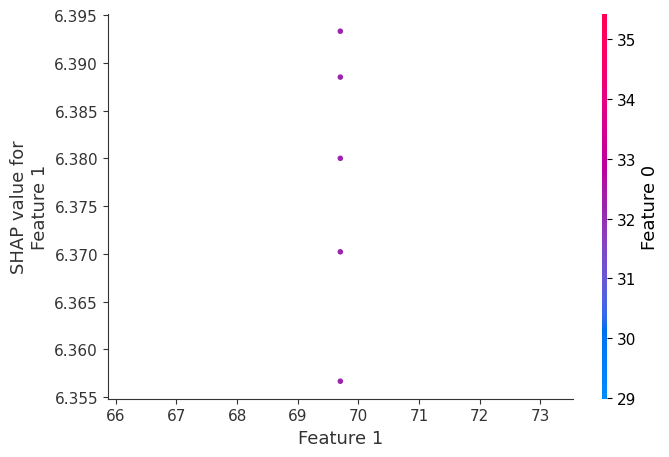

In [58]:
shap.dependence_plot("Feature 1", shap_values[0], x_test_0)